In [1]:
import numpy as np 
import pandas as pd 

In [2]:
df = pd.read_csv('apple_stock_data.csv')

In [3]:
df.head()

,date,open,high,low,close,volume
0,05/11/2020,77.029999,79.260002,76.809998,78.750000,145946240
1,05/12/2020,79.459999,79.919998,77.730003,77.849998,162301056
2,05/13/2020,78.040001,78.989998,75.800003,76.910004,200622560
3,05/14/2020,76.129997,77.449997,75.379997,77.389999,158929072
4,05/15/2020,75.089996,76.970001,75.050003,76.930000,166348384


In [4]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

#### Zero Missing Values

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

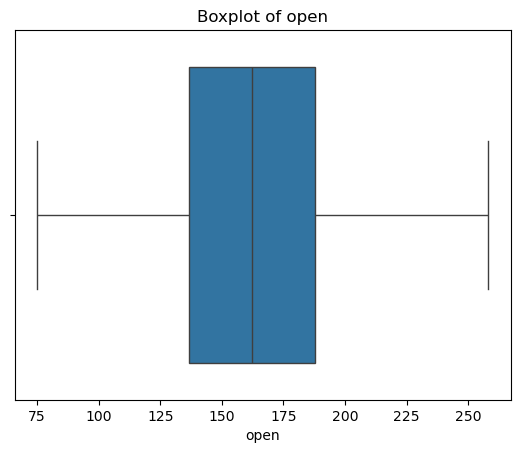

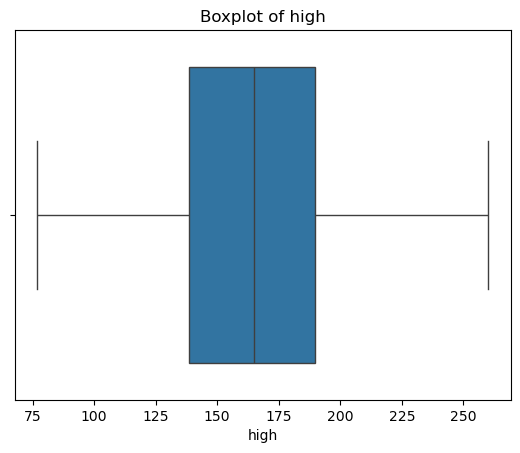

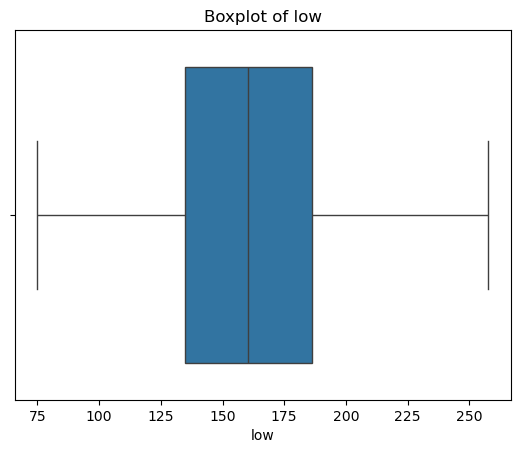

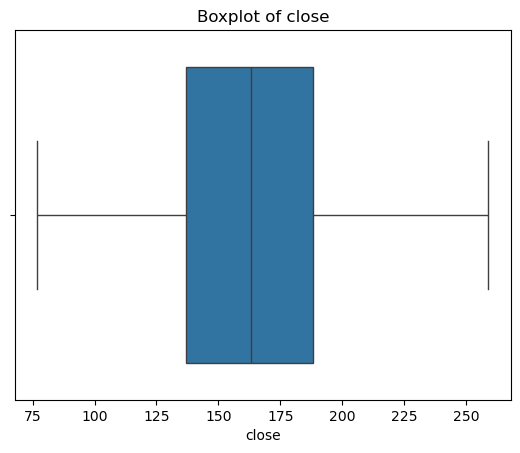

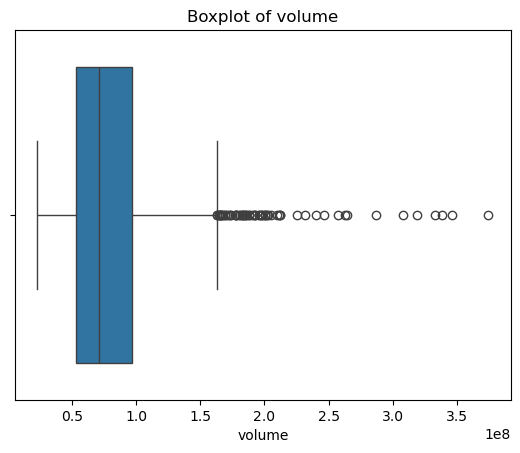

In [6]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [7]:
Q1 = df['volume'].quantile(0.25)
Q3 = df['volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['volume'] < lower_bound) | (df['volume'] > upper_bound)]

number_of_outliers = len(outliers)
percent_of_outliers = (number_of_outliers / len(df)) * 100
print(f'Number of outliers: {number_of_outliers} which is {percent_of_outliers:.2f}% of dataset.')

Number of outliers: 64 which is 5.10% of dataset.


#### Analysis of APPLE Stock Volume

The analysis reveals that APPLE stocks exhibit outliers in the `volume` column, particularly on high-volume trading days with 5.10% of data which is 64 as outliers.

In [8]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'])

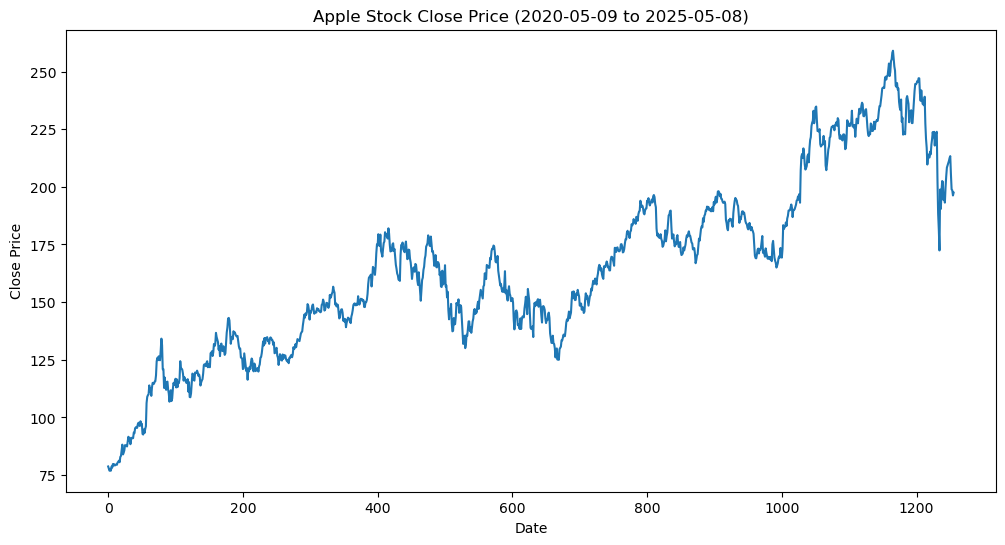

In [9]:
df['close'].plot(title='Apple Stock Close Price (2020-05-09 to 2025-05-08)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

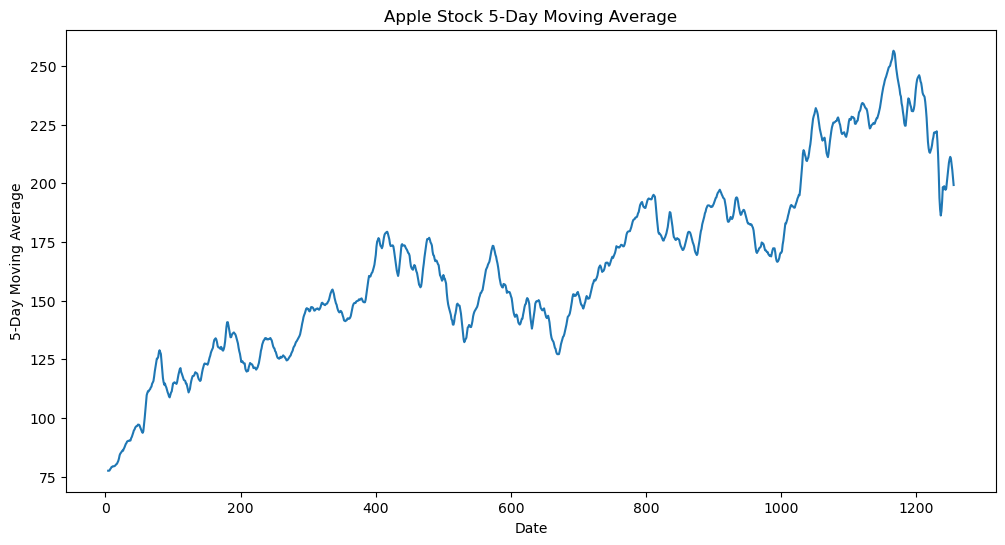

In [10]:
# One week moving average (monday to friday)
df.loc[:,'moving_average_5'] = df['close'].rolling(window=5).mean() #.loc used to avoid SettingWithCopyWarning

# Plot the moving average
df['moving_average_5'].plot(title='Apple Stock 5-Day Moving Average', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('5-Day Moving Average')
plt.show()

##### RSI ( Relative Strength Index), indicates speed and change of price movement (0-100), RSI > 70 (overbought), RSI < 30 (Oversold)


In [11]:
# Feature Engineer RSI
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = delta.clip(upper=0).abs()

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
df['RSI_14'] = rsi

In [12]:
# Engineer the target with a 1-day lag
# Target is the next day's close price
df['Target'] = df['close'].shift(-1)
# Drop nans
df.dropna(inplace=True)

In [13]:
# Extract date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [14]:
# Select features and target
X = df[['open', 'high', 'low', 'volume', 'moving_average_5', 'RSI_14', 'year', 'month', 'day']]
y = df['Target']

In [15]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 21.238793024242234
R^2 Score: 0.9244791103849225


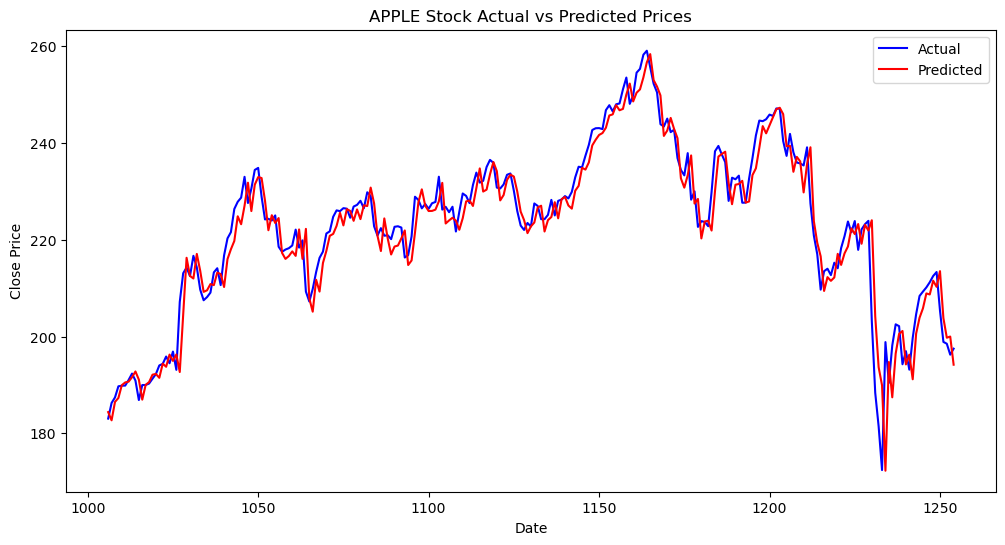

In [17]:
preds = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, preds, label='Predicted', color='red')
plt.legend()
plt.title('APPLE Stock Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

#### Linear Regression Model Results: Mean Squared Error: 21.238 and R^2 Score: 0.924

Mean Squared Error: 18.996837563029654
R^2 Score: 0.9324510544928055


c:\Users\Sachin\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Sachin\anaconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Sachin\anaconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+03, tolerance: 6.617e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

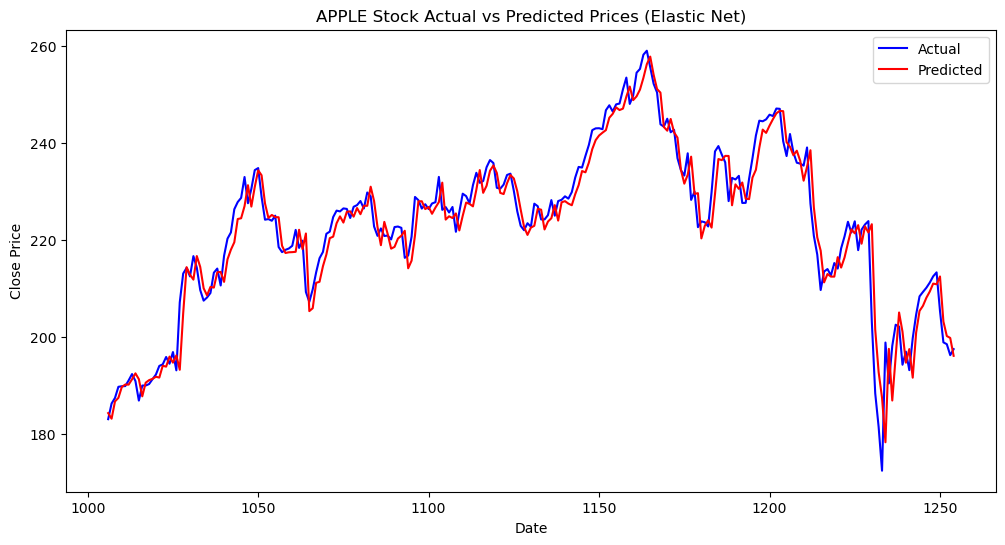

In [18]:
# Feature engineer percentage change column
df['Pct_Change'] = df['close'].pct_change().fillna(0)

features = ['open', 'high', 'low', 'volume', 'moving_average_5', 'RSI_14', 'year', 'month', 'day', 'Pct_Change']

X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(random_state=42, alpha=0, l1_ratio=1) # Default: alpha=1.0, l1_ratio=0.5
elastic_net.fit(x_train_scaled, y_train)
y_pred = elastic_net.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plot the elastic net graph
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('APPLE Stock Actual vs Predicted Prices (Elastic Net)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

